In [3]:
import pandas as pd
import matplotlib.pyplot as plt

In [41]:
from sklearn.cluster import KMeans
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Loading DataSet

In [4]:
data = pd.read_csv("/content/sales_data.csv")

## Checking for Missing Values

In [6]:
missing_values = data.isnull().sum()
print(missing_values)

order_id       0
date           0
customer_id    0
product_id     0
quantity       0
price          0
dtype: int64


## Finding types of each column

In [7]:
print("Data types:")
print(data.dtypes)

Data types of each column:
order_id         int64
date            object
customer_id      int64
product_id       int64
quantity         int64
price          float64
dtype: object


## Coverting date column to date type

In [8]:
data['date'] = pd.to_datetime(data['date'])

In [9]:
print("Data types:")
print(data.dtypes)

Data types:
order_id                int64
date           datetime64[ns]
customer_id             int64
product_id              int64
quantity                int64
price                 float64
dtype: object


## EDA

### Calculating Total Sales for each order

In [10]:
data['total_sales'] = data['quantity'] * data['price']

In [13]:
print("Updated DataFrame:")
print(data)

Updated DataFrame:
   order_id       date  customer_id  product_id  quantity  price  total_sales
0         1 2023-01-01          101         501         2   15.0         30.0
1         2 2023-01-02          102         502         1   25.0         25.0
2         3 2023-01-03          101         503         1   45.0         45.0
3         4 2023-02-01          103         501         3   15.0         45.0
4         5 2023-02-10          103         504         2   35.0         70.0
5         6 2023-03-05          105         505         5   10.0         50.0
6         7 2023-03-15          101         506         2   20.0         40.0
7         8 2023-04-01          102         507         4   30.0        120.0
8         9 2023-05-01          106         508         3   25.0         75.0
9        10 2023-06-01          107         509         2   50.0        100.0


In [19]:
top_products = data.groupby('product_id')['total_sales'].sum().nlargest(5)

### Trend over time

In [20]:
monthly_sales = data.groupby(data['date'].dt.to_period('M'))['total_sales'].sum()

In [21]:
print("Monthly Sales Trend:")
print(monthly_sales)

Monthly Sales Trend:
date
2023-01    100.0
2023-02    115.0
2023-03     90.0
2023-04    120.0
2023-05     75.0
2023-06    100.0
Freq: M, Name: total_sales, dtype: float64


### Top 5 products by Sales

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Axes: xlabel='Product ID', ylabel='Total Sales'>

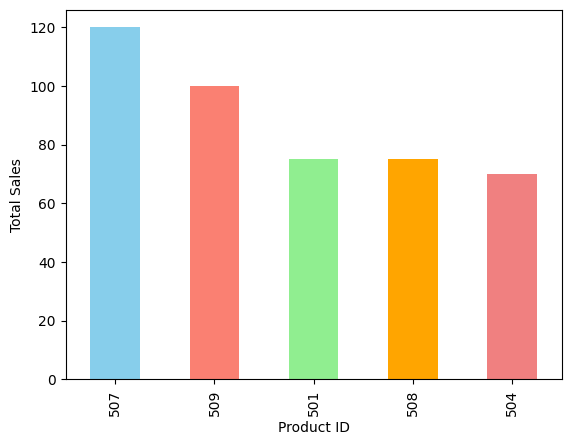

In [57]:
top_products.plot(kind='bar', xlabel='Product ID', ylabel='Total Sales', color=['skyblue', 'salmon', 'lightgreen', 'orange', 'lightcoral'])


### Customer Analysis

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0.5, 1.0, 'Sales per Customer')

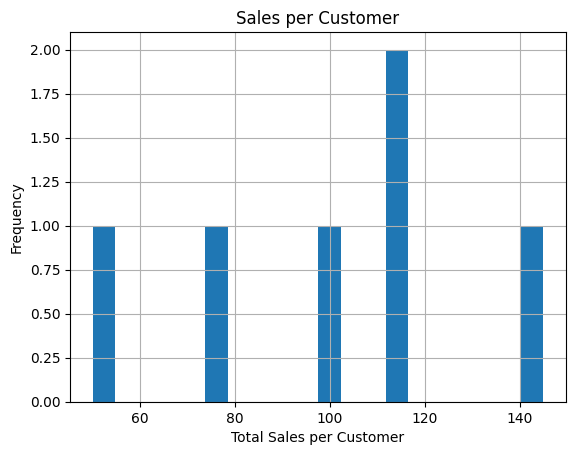

In [62]:
total_sales_per_customer = data.groupby('customer_id')['total_sales'].sum()
top_customers = total_sales_per_customer.nlargest(5)
total_sales_per_customer.hist(bins=20)
plt.xlabel('Total Sales per Customer')
plt.ylabel('Frequency')
plt.title('Sales per Customer')

### Product Analysis

Text(0.5, 1.0, 'Quantity Sold per Product')

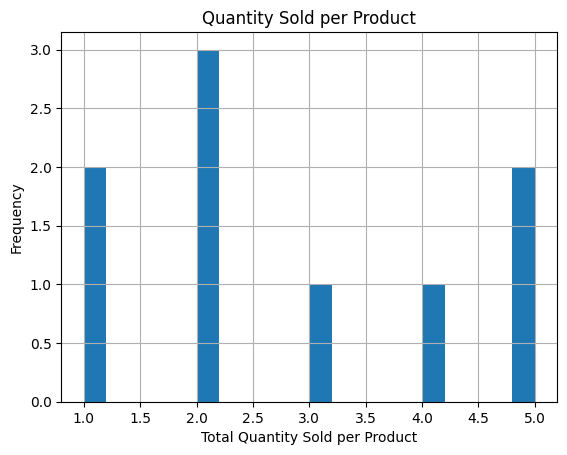

In [25]:
total_quantity_sold_per_product = data.groupby('product_id')['quantity'].sum()
total_quantity_sold_per_product.hist(bins=20)
plt.xlabel('Total Quantity Sold per Product')
plt.ylabel('Frequency')
plt.title('Quantity Sold per Product')

## Advanecd Analysis

### Average Over Value (AOV)

In [27]:
average_price_per_product = data.groupby('product_id')['price'].mean()

In [28]:
monthly_purchases_per_customer = data.groupby(['customer_id', data['date'].dt.to_period('M')])['order_id'].count().reset_index(name='purchase_count')
repeat_purchase_customers = monthly_purchases_per_customer[monthly_purchases_per_customer['purchase_count'] > 1]
customer_count = len(data['customer_id'].unique())
repeat_purchase_rate_over_time = len(repeat_purchase_customers) / customer_count

In [30]:
aov = data['total_sales'].mean()

In [29]:
print("Top 5 Customers by Total Sales:")
print(top_customers)
print("Average Price per Product:")
print(average_price_per_product)
print("Repeat Purchase Rate Over Time:", repeat_purchase_rate_over_time)

Top 5 Customers by Total Sales:
customer_id
102    145.0
101    115.0
103    115.0
107    100.0
106     75.0
Name: total_sales, dtype: float64
Average Price per Product:
product_id
501    15.0
502    25.0
503    45.0
504    35.0
505    10.0
506    20.0
507    30.0
508    25.0
509    50.0
Name: price, dtype: float64
Repeat Purchase Rate Over Time: 0.3333333333333333


### Repeat purchase rate

In [32]:
repeat_purchase_rate = (data['customer_id'].value_counts() > 1).mean()

In [33]:
print("Average Order Value (AOV):", aov)
print("Repeat Purchase Rate:", repeat_purchase_rate)

Average Order Value (AOV): 60.0
Repeat Purchase Rate: 0.5


## Customer Segmentation

In [36]:
customer_features = data.groupby('customer_id').agg({
    'total_sales': 'sum',
    'order_id': 'count',
    'total_sales': 'mean'
}).reset_index()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [37]:
kmeans = KMeans(n_clusters=3, random_state=42)
customer_features['cluster'] = kmeans.fit_predict(customer_features.drop('customer_id', axis=1))


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


### Market Basket Analysis

In [38]:
basket = data.groupby(['order_id', 'product_id'])['quantity'].sum().unstack().reset_index().fillna(0).set_index('order_id')
basket_encoded = basket.applymap(lambda x: 1 if x > 0 else 0)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [39]:
frequent_itemsets = apriori(basket_encoded, min_support=0.05, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/mlxtend/frequent_patterns/fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [40]:
print("Customer Segmentation:")
print(customer_features)
print("Association Rules:")
print(rules)

Customer Segmentation:
   customer_id  total_sales  order_id  cluster
0          101    38.333333         3        0
1          102    72.500000         2        2
2          103    57.500000         2        0
3          105    50.000000         1        0
4          106    75.000000         1        2
5          107   100.000000         1        1
Association Rules:
Empty DataFrame
Columns: [antecedents, consequents, antecedent support, consequent support, support, confidence, lift, leverage, conviction, zhangs_metric]
Index: []


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
